# Майнор "Прикладные задачи анализа данных"
## Домашнее задание 2 [10 баллов] до 23:59 22.03.2018. Предсказание цены акции по экономическим новостям


В этом домашнем задании вы попытаетесь предсказать рост цены акции компании Газпром по новостям о компании. Домашнее задание состоит из трех частей:
1. Предварительная обработка текстов и эксплоративный анализ
2. Baseline алгоритм
3. Творческая часть

Все три части можно считать независимыми – вы можете сделать одну или две из них, однако мы настоятельно советуем выполнить все три. Все инструкции по выполнению домашнего задания – ниже. 



Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('texts.csv')
df.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [3]:
df.text[1]

' Как и предполагал “Ъ”, «Газпром», воспользовавшись жалобами иностранных партнеров на налогообложение добычных проектов в РФ, смог добиться снижения налога на добычу полезных ископаемых (НДПИ) для своих ачимовских залежей почти до уровня независимых производителей газа. Эта льгота распространится не только на СП «Газпрома» с OMV и Wintershall, но и на структуры монополии, разрабатывающие месторождения с запасами от 1 трлн кубометров газа. По расчетам “Ъ”, это приведет к тому, что в 2018 году платеж по НДПИ для «Газпрома» и его ачимовских СП снизится на 2,8 млрд руб., из которых 2,2 млрд руб. сэкономит сама монополия.'

In [4]:
pr_all = pd.read_csv('gazprom_prices.csv', sep=';')
pr_all.head(5)

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,"133,43000","132,60000","133,90000","132,00000",16037970
1,07.12.2017,"133,70000","133,02000","133,87000","132,81000",18198430
2,06.12.2017,"133,33000","134,00000","134,29000","132,91000",14641730
3,05.12.2017,"133,48000","133,65000","133,99000","132,78000",12684800
4,04.12.2017,"133,01000","133,77000","134,00000","131,93000",17818980


## Часть 1. Вводная [3 балла]

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* Кого упоминают чаще:
    * Алексея Миллера
    * Владимира Путина?
* О каких санкциях пишут в статьях?

### Предобработка текстов: *выполнена токенизация, лемматизация, приведение к нижнему регистру и удаление стоп-слов*

*Два варианта: через mystem3 и через pymorphy2, но далее тексты обработаны с помощью второй библиотеки (с mystem3 долго работает).*
```
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem

def texts_to_words(text):
    pattern = re.compile("[А-Яа-яёA-Za-z+\-?А-Яа-яёA-Za-z]+")
    rows = pattern.findall(text)
    m = Mystem()
    words = m.lemmatize(' '.join(rows))
    for word in words:
        res = re.search(pattern, word)
        if res is None:
            words.remove(word)
    answer = [token.lower() for token in words if not token in stopwords.words('russian')]
    return answer 
```

In [6]:
import re
import pymorphy2
import nltk
from nltk.corpus import stopwords

def texts_to_words(text):
    prog = re.compile("[А-Яа-яёA-Za-z]+")
    line = prog.findall(str(text).lower()) 
    morph = pymorphy2.MorphAnalyzer()
    words = [morph.parse(token)[0].normal_form for token in line if not token in stopwords.words('russian')]
    return words
    
for i in range(df.shape[0]):
    df.text[i] = texts_to_words(df.text[i])


 **Есть ли корреляция между средней длиной текста и за день и ценой закрытия?** (1/5)

Q?
> - что такое средняя длина текста? (вообще, в df один текст в день)
> + стоит значения перевести в float

In [7]:
df = df.rename(columns = {'date':'Date'}) 
#создаем датафрейм, в котором для каждого дня есть и цена закрытия, и текст (в изначальных данных есть пропуски)
data = pd.merge(df, pr_all, how='inner', on=['Date']) 

In [8]:
#создаем столбец с длинами текстов
data['length'] = data.apply(lambda row: len(row[1]), axis=1) 

In [9]:
#переводим значения столбца ClosingPrice в тип float
for i in range(data.shape[0]):
    data['ClosingPrice'][i] = data['ClosingPrice'][i].replace(',', '.')
data.ClosingPrice = pd.to_numeric(data.ClosingPrice, downcast='float')

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
print('Корреляция между длиной текста и ценой закрытия:', pd.Series.corr(data['length'], data['ClosingPrice']))

Корреляция между длиной текста и ценой закрытия: 0.013983072031782404


**Есть ли корреляция между количеством упоминаний Алексея Миллера и ценой закрытия? Учтите разные варианты написания имени.** (2/5)

> * но ведь нет никаких других вариантов написания?..

In [11]:
def count_mntns(lst):
    if isinstance(lst, float):
        return 0
    else:
        return lst.count('миллер')

In [12]:
#создаем столбец с количеством упоминаний А.Миллера в тексте
data['mentions'] = data.apply(lambda row: count_mntns(row[1]), axis=1)

In [13]:
print('Корреляция между количеством упоминаний Алексея Миллера и ценой закрытия:', pd.Series.corr(data['mentions'], data['ClosingPrice']))

Корреляция между количеством упоминаний Алексея Миллера и ценой закрытия: 0.010635075047145011


**Упоминаний какого газопровода в статьях больше:**
 > * "северный поток"
 > * "турецкий поток"?  (3/5)

In [14]:
#df - изначальный датафрейм с текстами
texts_with = [] #оставим только подходящие тексты
for i in range(df.shape[0]):
    if (df.text[i].count('поток') > 0) or (df.text[i].count('stream') > 0):
        texts_with += df.text[i]

In [15]:
#ищем коллокации
import nltk
from nltk.collocations import *
finder = BigramCollocationFinder.from_words(texts_with)

In [16]:
#фильтрация коллокаций
words = ['stream', 'поток']
collo_filter = lambda w1, w2: w2 not in words
finder.apply_ngram_filter(collo_filter)

In [17]:
#сортировка коллокаций по убыванию
a = sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:] 
print([item for item in a])

[(('nord', 'stream'), 80), (('south', 'stream'), 56), (('южный', 'поток'), 49), (('турецкий', 'поток'), 39), (('северный', 'поток'), 15), (('денежный', 'поток'), 11), (('голуба', 'поток'), 4), (('blue', 'stream'), 2), (('голубой', 'поток'), 1), (('дать', 'поток'), 1)]


*Если важны только конкретные словосочетания "северный поток" и "турецкий поток", то Турецкий поток встречается чаще. Но в текстах также используется английский вариант названия, поэтому учитывая "nord stream", количество упоминаний Северного потока превывашет количество упоминаний Турецкого. Вообще, Турецкий поток - проект газопровода, который был предложен вместо Южного потока и при желании можно учесть и этот факт.*

**Кого упоминают чаще:** (4/5)
   * Алексея Миллера
   * Владимира Путина?

In [18]:
texts_vp = [] #оставим только подходящие тексты
for i in range(df.shape[0]):
    if (df.text[i].count('путин') > 0) or (df.text[i].count('миллер') > 0):
        texts_vp += df.text[i]

In [19]:
print(texts_vp.count('миллер'))
print(texts_vp.count('путин'))

151
73


*Миллер встречается чаще.
Стоит отметить, что упоминание Путина и Миллера необязательно предполагает наличие коллокаций с их именами. В отличие от предыдущего пункта, где слово "поток" употреблялось неоднозначно (в текстах есть "денежный поток" и т.д.), здесь под фамилиями Путин и Миллер мы явно понимаем Владимира Путина и Алексея Миллера, поэтому смотреть на все коллокации не кажется необходимым (но на всякий случай, мы посмотрим :) )*

In [20]:
finder = BigramCollocationFinder.from_words(texts_vp)
words = ['путин', 'миллер']
new_filter = lambda w1, w2: w2 not in words
finder.apply_ngram_filter(new_filter)

In [21]:
a = sorted(finder.ngram_fd.items(), key=lambda t: (-t[1], t[0]))[:] 
print([item for item in a])

[(('алексей', 'миллер'), 125), (('владимир', 'путин'), 67), (('сказать', 'миллер'), 13), (('заявить', 'миллер'), 2), (('поздний', 'миллер'), 2), (('сказать', 'путин'), 2), (('слово', 'путин'), 2), (('встреча', 'миллер'), 1), (('господин', 'миллер'), 1), (('подарок', 'миллер'), 1), (('предположение', 'миллер'), 1), (('проект', 'миллер'), 1), (('разговор', 'миллер'), 1), (('секретарь', 'путин'), 1), (('слово', 'миллер'), 1), (('украина', 'миллер'), 1), (('уточнить', 'путин'), 1), (('цель', 'миллер'), 1)]


*Можно так еще посмотреть:*

In [22]:
data_text = []
for i in range(df.shape[0]):
    data_text += df.text[i]

In [23]:
from nltk.text import Text  
text1 = Text(data_text)
text1.collocations(30)

миллиард рубль; газпром нефть; алексей миллер; куб метр; совет
директор; говориться сообщение; поставка газа; nord stream; газпром
медиа; председатель правление; владимир путин; миллиард кубометр;
стать известно; чистый прибыль; south stream; оао газпром; сей пора;
lietuvos dujos; александр медведев; пресс служба; независимый
производитель; геннадий тимченко; нафтогаз украина; миллиард куб;
южный поток; сила сибирь; газовый холдинг; прошлое год; цена газ;
природный газа


**О каких санкциях пишут в статьях?** (5/5)
* может вывести прилагательные, которые употребляются со словом санкция? 
* чем отличается concordance отличается от common_contexts?

In [24]:
print(text1.concordance("санкция", width=100, lines=68))

Displaying 68 of 69 matches:
ить сам монополия новый редакция американский санкция ставить угроза зарубежный нефтяной проект рос
слово источник ъ участок интересоваться shell санкция иностранец год шельф россия пока идти газпром
слово источник ъ участок интересоваться shell санкция иностранец год шельф россия пока идти спутник
ность испанский компания рф наблюдаться число санкция эксперт полагать сила опыт организация парите
ность испанский компания рф наблюдаться число санкция эксперт полагать сила опыт организация парите
е почему лизингодатель почувствовать западный санкция ъ рассказать гендиректор газпромбанк лизинг м
оюз подтвердить правомерность ввести совет ес санкция отношение роснефть брюссель запретить предост
акой положение дело недовольный грозить банка санкция территория украина крупный российский банка с
акой положение дело недовольный грозить банка санкция территория украина казахстан подтвердить план
работка южный киринский месторождение попасть санкция мнение эксперт по

In [25]:
text1.common_contexts(['санкция'], num=68)

американский_ставить shell_иностранец число_эксперт западный_ъ
ес_отношение банка_территория попасть_мнение осложнять_сша
находиться_банка фон_начинать западный_против нефть_работа
очередной_перевод западный_затрагивать экономический_против
крым_репутационный введение_против антироссийский_конвертировать
персональный_рнкб риска_сторона несмотря_проблема условие_падение
ожидать_оказать последствие_компания затронуть_оказывать
штрафной_несогласованный влияние_финансовый влияние_считать
западный_готовый число_западный волна_проигнорировать волна_объявить
развитие_объяснить поскольку_газпром партнёр_вслед shell_мочь
уверять_никак секторальный_сша использовать_против подпасть_сша
западный_технологический эффект_проявиться западный_список
введение_предоставление сила_меняться виток_сторона запрет_мочь
попасть_сша компания_один россия_сообщить финансовый_который
ситуация_мочь ввести_компания ждать_пока международный_куб
штрафной_монополия штрафной_нарушение


*В статьях пишут об антироссийских, западных, финансовых, международных, экономических, персональных санкциях*

## Часть 2. Классификационная [3 балла]
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [26]:
#data - объединенный датафрейм, где в каждой строке есть текст и цена закрытия
data = data.iloc[::-1]
data.index = range(len(data))
data.head()

,Date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,length,mentions
0,11.01.2010,"[спорный, вопрос, оплата, оказать, период, год...","192,50000",194.500000,"196,90000","191,00000",59815603,48,0
1,19.01.2010,"[газпром, готовый, забирать, весь, объесть, аз...","190,10000",189.759995,"190,47000","187,36000",48626727,44,2
2,28.01.2010,"[консорциум, глава, российский, оао, газпром, ...","183,75000",182.300003,"185,98000","181,67000",62561241,58,0
3,01.02.2010,"[газпром, исключать, год, выпуск, облигация, п...","184,74000",189.850006,"190,40000","183,50000",76298175,25,0
4,03.02.2010,"[переговоры, оао, газпром, оператор, проект, с...","194,00000",192.699997,"195,27000","192,30000",74730185,22,0


In [27]:
def binary(data_col):
    binary_array=[0]
    for i in range(len(data_col)-1):
        if data_col[i+1]>=data_col[i]:
            binary_array.append(1)
        else:
            binary_array.append(0)
    return binary_array
    
data['ClosingPrice_bin'] = binary(data['ClosingPrice'])

In [28]:
data.head()

,Date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,length,mentions,ClosingPrice_bin
0,11.01.2010,"[спорный, вопрос, оплата, оказать, период, год...","192,50000",194.500000,"196,90000","191,00000",59815603,48,0,0
1,19.01.2010,"[газпром, готовый, забирать, весь, объесть, аз...","190,10000",189.759995,"190,47000","187,36000",48626727,44,2,0
2,28.01.2010,"[консорциум, глава, российский, оао, газпром, ...","183,75000",182.300003,"185,98000","181,67000",62561241,58,0,0
3,01.02.2010,"[газпром, исключать, год, выпуск, облигация, п...","184,74000",189.850006,"190,40000","183,50000",76298175,25,0,1
4,03.02.2010,"[переговоры, оао, газпром, оператор, проект, с...","194,00000",192.699997,"195,27000","192,30000",74730185,22,0,1


In [29]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)  
date = pd.to_datetime('31.12.2015')
mask = (data['Date'] <= date) 
train_data = data.loc[mask]
test_data = data.loc[np.logical_not(mask)]

In [30]:
test_data.head()

,Date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,length,mentions,ClosingPrice_bin
901,2016-01-11,"[россия, продолжать, жёсткий, курс, отношение,...","133,00000",131.380005,"133,65000","131,10000",34008830,59,0,0
902,2016-01-13,"[новатэк, прошлое, год, увеличить, добыча, газ...","134,17000",131.300003,"134,48000","131,20000",30807200,47,0,0
903,2016-01-14,"[слогать, газпром, национальный, достояние, ис...","130,99000",130.860001,"131,49000","129,01000",43969320,61,0,0
904,2016-01-15,"[газпром, остановить, закупка, туркменский, га...","130,31000",125.099998,"132,43000","125,05000",62125020,106,0,0
905,2016-01-18,"[газпром, далёкий, либо, зайти, конфликт, турк...","124,80000",124.599998,"126,30000","122,75000",36024930,42,0,0


In [31]:
X_train = []
for row in train_data['text']:
    X_train.append(' '.join(row))
X_test = []
for row in test_data['text']:
    X_test.append(' '.join(row))

In [32]:
y_train = np.array(train_data['ClosingPrice_bin'])#.reshape(-1, 1)
y_test =  np.array(test_data['ClosingPrice_bin'])#.reshape(-1, 1)

In [33]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.fit_transform(X_test)

In [34]:
#lsa
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.fit_transform(X_test_tfidf)

In [39]:
#lda
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=2, max_iter=50, learning_method='batch')
X_train_lda = lda.fit_transform(X_train_tfidf)
X_test_lda = lda.fit_transform(X_test_tfidf)

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [40]:
from sklearn.metrics import f1_score

In [41]:
from sklearn.preprocessing import MinMaxScaler
X_train_norm = MinMaxScaler().fit_transform(X_train_svd)
X_test_norm = MinMaxScaler().fit_transform(X_test_svd)

In [150]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
mnb = MultinomialNB(alpha=9.011018251665037)
mnb.fit(X_train_tfidf, y_train)
y_pred = mnb.predict(X_test_tfidf)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.5503875968992248
0.32558139534883723


In [43]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 1, max_depth=2, random_state=0)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.5813953488372093
0.11475409836065573


In [44]:
from sklearn.neighbors import KNeighborsClassifier
treeclf = KNeighborsClassifier(5)
treeclf.fit(X_train_lda, y_train)
y_pred = treeclf.predict(X_test_lda)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.5465116279069767
0.4608294930875576


Helpers.
Пришлось реализовать свою f-меру, т.к. была проблема в гридсерче, что в знаменателе ноль на некоторых параметрах и все крашится, я в таком случае просто зануляю, что впринципе верно. 

In [134]:
def f_mera(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    TP = 0.
    FP = 0.
    TN = 0.
    FN = 0.
    for i in range(len(y_true)):
        if (y_true[i] == y_pred[i] and
            y_pred[i] == 1):
            ++TP
        elif (y_true[i] == y_pred[i] and
              y_pred[i] == 0):
            ++TN
        elif (y_true[i] != y_pred[i] and
              y_pred[i] == 1):
            ++FP
        elif (y_true[i] == y_pred[i] and
              y_pred[i] == 0):
            ++FN
    if TP + FP == 0 or TP + FN == 0:
        return 0
    prec = TP/(TP + FP)
    rec = TP/(TP + FN)
    if prec + rec == 0:
        return 0
    return (2*prec*rec/(prec+rec))

In [135]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
right_answers = make_scorer(accuracy_score, greater_is_better = True)
f_score = make_scorer(f_mera, greater_is_better = True)
kf = KFold(n_splits=10, random_state=123)

Я не стал мусорить в ноутбуке всеми видами классификаторов, но могу сказать, что попробовал абсолютно все, которые мне известны, смотрел на F-меру и на accuracy, оставил лучшие три.
Вообще, мне кажется, что удивляться такой низкой оценке не приходится, т.к. сама задача в общем смысле весьма сложная, а данные очень простые + даже если брать в счет только новости, у ни зависимости сильно сложнее, чем мы предполагаем. То есть такие результаты без доп. методов абсолютно нормальны.

Теперь для лучших (:D) методов попробуем гридсерчем подобрать параметры и вывести графики:

GridSearch accuracy MNB

Виден тред с тем, что чем сложнее модель, тем хуже она обобщает для таких данных, что логично.

In [142]:
alphas = np.logspace(-10, 10, 200, base=10)
alphas = np.append(alphas, np.linspace(1, 5, 100))

In [143]:
from sklearn.model_selection import GridSearchCV
mnb_search = MultinomialNB(alpha=list(alphas))
param_dict_mnb = {'alpha': list(alphas)} 
grid_mnb = GridSearchCV(estimator=mnb_search, cv=kf, param_grid = param_dict_mnb, scoring = right_answers)
grid_mnb.fit(X_train_norm, y_train)
error_test_mnb = grid_mnb.cv_results_.get('mean_test_score')
error_train_mnb = grid_mnb.cv_results_.get('mean_train_score')

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Text(0.5,1,'train')

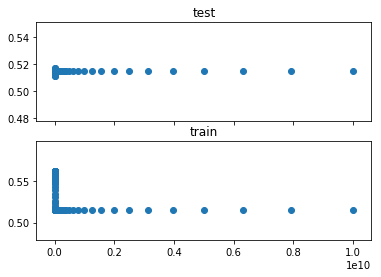

In [144]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].scatter(alphas, error_test_mnb)
axarr[0].set_title('test')
axarr[1].scatter(alphas, error_train_mnb)
axarr[1].set_title('train')

GridSearch my f_mera MNB

In [151]:
from sklearn.model_selection import GridSearchCV
grid_mnb_f = GridSearchCV(estimator=mnb_search, cv=kf, param_grid = param_dict_mnb, scoring = f_score)
grid_mnb_f.fit(X_train_tfidf, y_train)
error_test_mnb_f = grid_mnb_f.cv_results_.get('mean_test_score')
error_train_mnb_f = grid_mnb_f.cv_results_.get('mean_train_score')

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Text(0.5,1,'train')

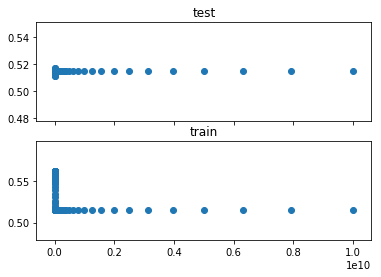

In [152]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].scatter(alphas, error_test_mnb_f)
axarr[0].set_title('test')
axarr[1].scatter(alphas, error_train_mnb_f)
axarr[1].set_title('train')

GridSearch Knn f accuracy.

С кнн все наоборот, при малом кол-ве соседей видно переобучение

In [163]:
knn_a = KNeighborsClassifier()
n_neighbors_list = range(1, 100)
param_dict_knn = {'n_neighbors': n_neighbors_list} 
grid_knn = GridSearchCV(estimator=knn_a, cv=kf, param_grid = param_dict_knn, scoring = right_answers)
grid_knn.fit(X_train_norm, y_train)
error_test_knn = grid_knn.cv_results_.get('mean_test_score')
error_train_knn = grid_knn.cv_results_.get('mean_train_score')

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Text(0.5,1,'train')

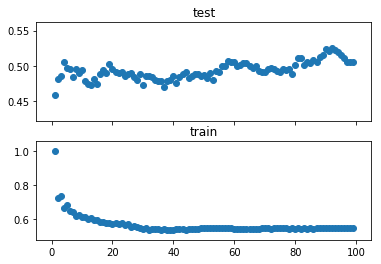

In [164]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].scatter(n_neighbors_list, error_test_knn)
axarr[0].set_title('test')
axarr[1].scatter(n_neighbors_list, error_train_knn)
axarr[1].set_title('train')

In [ ]:
grid_knn.best_params_

GridSearch Randomforest accuracy

Мне показалось, что лес лучше всех работает, притом на малом кол-ве деревьев с малой глубиной, что подтверждает идею простоты данных.

In [166]:
rnn_a = RandomForestClassifier()
est_list = range(2, 100)
depth_list = range(1,10)
param_dict_rnn = {'n_estimators': est_list,
                   'max_depth': depth_list} 
grid_rnn = GridSearchCV(estimator=rnn_a, cv=kf, param_grid = param_dict_rnn, scoring = right_answers)
grid_rnn.fit(X_train_norm, y_train)
error_test_rnn = grid_rnn.cv_results_.get('mean_test_score')
error_train_rnn = grid_rnn.cv_results_.get('mean_train_score')

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [171]:
par = []
for x in est_list:
    for y in depth_list:
        par.append([x, y])

Text(0.5,1,'train')

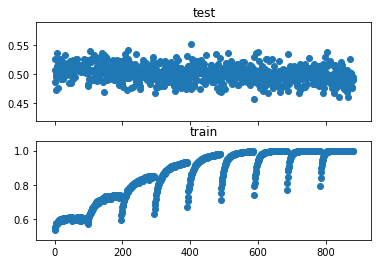

In [177]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].scatter(range(len(error_test_rnn)), error_test_rnn)
axarr[0].set_title('test')
axarr[1].scatter(range(len(error_test_rnn)), error_train_rnn)
axarr[1].set_title('train')

Вааааааааууу

## Часть 3. Творческая [4 балла]
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по усредненным эмбеддингам  (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/ или https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     

## Сдача домашнего задания

Дедлайн сдачи домашнего задания:  23:59 22.03.2018. Каждый день просрочки дедлайна штрафуется -1 баллом.

Результаты домашнего задания должны быть оформлены в виде отчета в jupyter notebook.
Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание минимума необходимой теории и/или описание используемых инструментов 
* Подробный пошаговый рассказ о проделанной работе
* **Аккуратно** оформленные результаты
* Подробные и внятные ответы на все заданные вопросы 
* Внятные выводы – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Задание выполняется в группе до трех человек. Не забудьте перечислить фамилии всех, кто работал над домашнем задании, в jupyter notebook.  

В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку (поскольку другие тоже могут на него наткнуться). Плагиат наказывается нулём баллов за задание и предвзятым отношением в будущем.


При возникновении проблем с выполнением задания обращайтесь с вопросами к преподавателю по семинарским занятиям в вашей группе или у учебным ассистентам.

Учебный ассистент по ДЗ 2: Таисия Глушкова (email: glushkovato@gmail.com, telegram: @glushkovato).


Небрежное оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в отчете в явном виде.

Сдача отчетов осуществляется через систему AnyTask.

